In [19]:
import os
import sys
import warnings

# Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
# if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer

if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')



In [20]:
Model_Name   = 'Model_NLRE_with_Conv3d'
Model_Name   = 'Model_NLRE_with_Conv3d_BatchShuffle'
Model_Name   = 'Model_NLRE_with_Conv3d_AllIn_BatchShuffle'
# Model_Name   = 'Model_NLRE_with_Conv3d_AllIn_BatchShuffle_SDPOnly'


Dataset_Name = 'NLRE_Dataset'

In [21]:
hostname

posix.uname_result(sysname='Linux', nodename='tycho.physics.adelaide.edu.au', release='3.10.0-1160.88.1.el7.x86_64', version='#1 SMP Tue Mar 7 15:41:52 UTC 2023', machine='x86_64')

#### Loading Data and Models, Processing Predictions

In [22]:
if 'tycho' in hostname or 'tycho' in hostname.nodename:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/NLREapproach/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/NLREapproach/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/NLREapproach/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/NLREapproach/Data/'

# append models path to path
sys.path.append(Models_Path)


In [23]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt')
print(Model.Description)


    Convolutional Neural Network which takes in 3d Traces and reconstruction values
    Uses ConvSkip Blocks with Conv3d Layers
    Reconstruction is done for one telescope
    No pooling is done, because it ruins the resolution
    Final output is a likelyhood estimation of each reconstruction value being correct

    This model plugs in all (other than the predicted value) reconstruction values into dense layers
    Uses Batch Shuffle augmentation
    


In [24]:
# Import Dataset Here

# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
print(Dataset.Name)
print(Dataset.Truth_Keys)
print(f'Dataset Length : {len(Dataset)}')
Dataset.AssignIndices()
Dataset.State = 'Train'
print(len(Dataset))

Unassigned_CDEsDataset
('LogE', 'Xmax', 'Chi0', 'Rp', 'SDPTheta', 'SDPPhi')
Dataset Length : 375911
263137


In [25]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 6 
Final Loss              : 5.553761347432545
Final Validation Loss   : 14.957945823669434


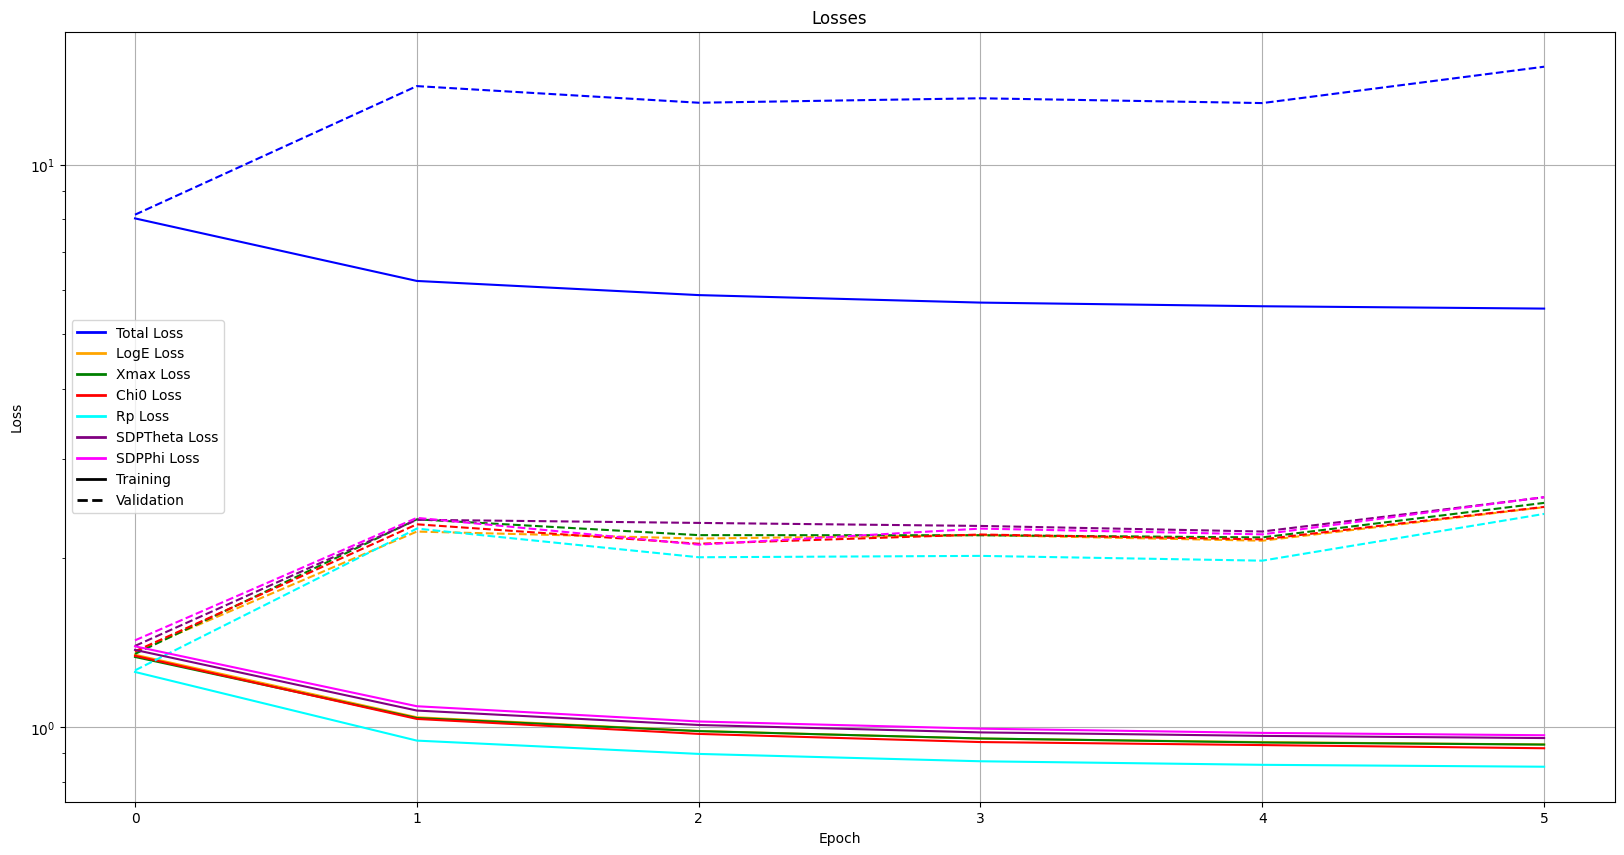

In [26]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

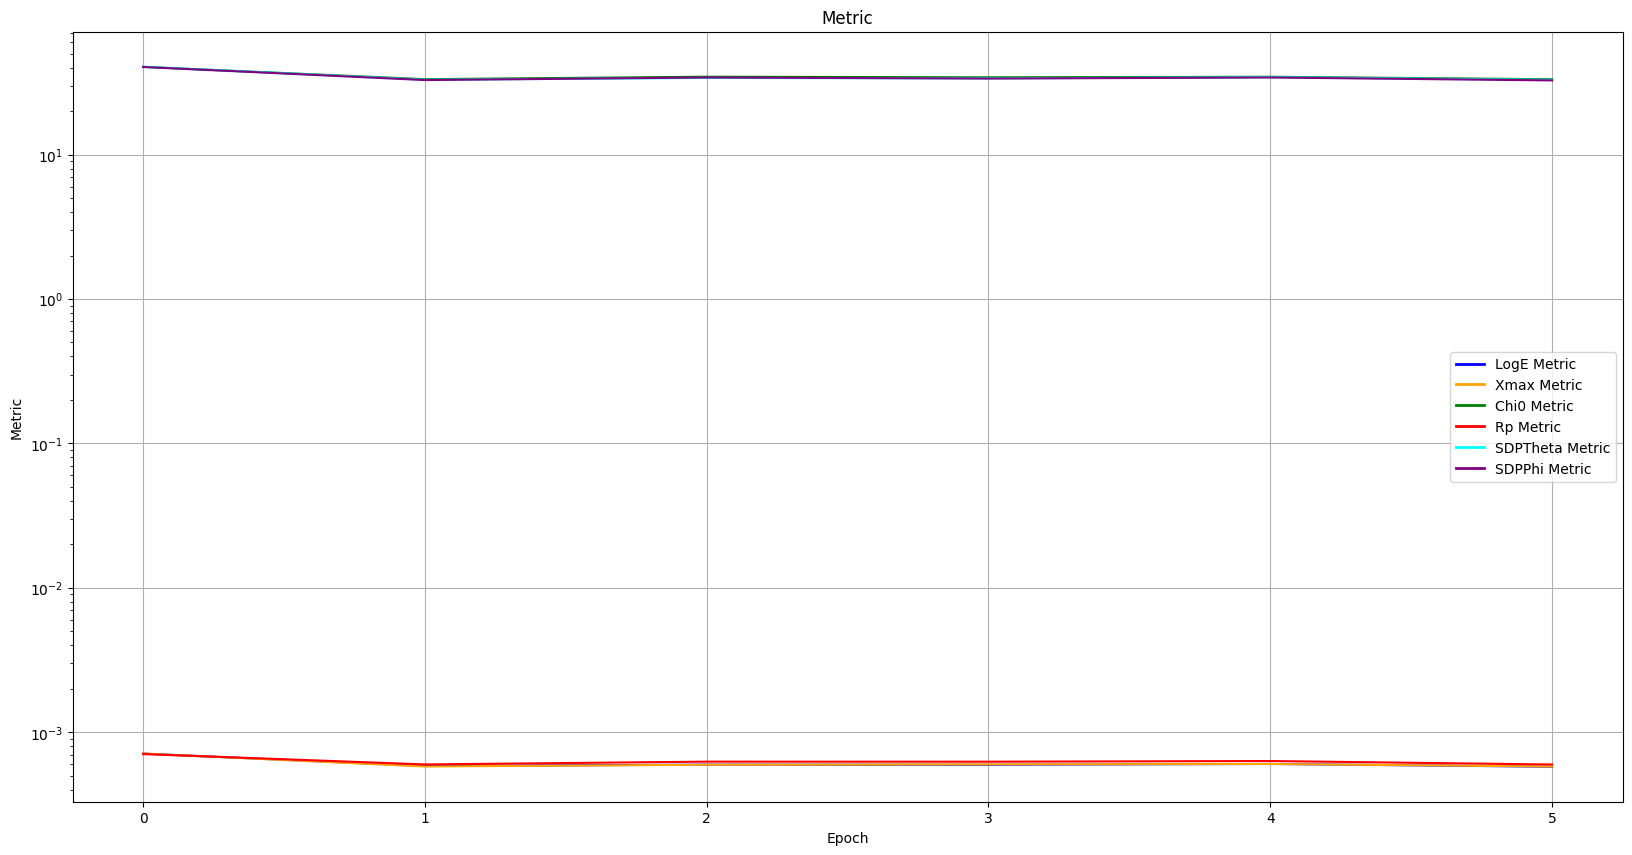

In [27]:
# Metric Plot

# Loss Plot
EpochMetrics    = Tracker.EpochMetric
Keys  = Dataset.Truth_Keys
Units = Dataset.Truth_Units
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    if   Units[i] == 'deg': plt.plot(np.array(EpochMetrics[Keys[i]]), color=colors[i], label=Keys[i] + ' - Metric')
    elif Units[i] == 'rad': plt.plot(np.array(EpochMetrics[Keys[i]])*180/np.pi, color=colors[i], label=Keys[i] + ' - Metric')
    else                  : plt.plot(np.array(EpochMetrics[Keys[i]])/1000     , color=colors[i], label=Keys[i] + ' - Metric')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Metric')



ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Metric')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metric')
ax.set_yscale('log')
ax.grid()

In [28]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [29]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
Model.to(device)
torch.cuda.empty_cache()

Dataset.State      = 'Test'
# Dataset.BatchSize  = len(Dataset)//256
Dataset.BatchSize  = 64
Dataset.RandomIter = False

Truth   = []
Rec     = []
Pred    = []
RecVals = []


Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # print(f'Event {EvI}/{len(Dataset)}', end='\r')
        # Send to device
        # BatchMains = [Main.to(device) for Main in BatchMains]
        # BatchAux   = BatchAux.to(device)
        # BatchAux[] = Dataset._Aux.mean(dim=0)

        Truth .append(BatchTruth)
        Rec   .append(BatchRec)
        
        Model_Out = Model(BatchMains, BatchAux)
        Pred   .append(Model_Out[0].cpu())
        RecVals.append(Model_Out[1].cpu())
        
        
        EvI+=1
        # if EvI == 10: break

print()
Truth   = torch.cat(Truth  , dim=0)
Rec     = torch.cat(Rec    , dim=0)
Pred    = torch.cat(Pred   , dim=0)
RecVals = torch.cat(RecVals, dim=0)

# Augmentation scale
Augmetation_Scale = RecVals.shape[0] // Truth.shape[0]
Truth = Truth.repeat_interleave(Augmetation_Scale, dim=0)
Rec   = Rec  .repeat_interleave(Augmetation_Scale, dim=0)

Truth_labels = (RecVals == Truth).float()
Pred_labels  = (Pred > 0.5 ).float()




Truth   = Truth.numpy()
Rec     = Rec  .numpy()
Pred    = Pred .numpy()
RecVals = RecVals.numpy()

Truth_labels = Truth_labels.numpy()
Pred_labels  = Pred_labels.numpy()



print(Truth.shape)
print(Pred.shape)




(75184, 6)
(75184, 6)


In [30]:
print(f'Augmetation_Scale: {Augmetation_Scale}')

Augmetation_Scale: 2


In [31]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

# Metric is Accuracy for classification this time


for i in range(len(TruthKeys)):
    Key = TruthKeys[i]

    Accuracy = (Truth_labels[:,i] == Pred_labels[:,i]).mean()
    print(f'Accuracy for {Key:15s} : {Accuracy*100:6.2f} %')
    

Accuracy for LogE            :  56.85 %
Accuracy for Xmax            :  56.98 %
Accuracy for Chi0            :  57.27 %
Accuracy for Rp              :  59.00 %
Accuracy for SDPTheta        :  56.68 %
Accuracy for SDPPhi          :  56.27 %


In [32]:
print(f'Truth Labels Positive percentage = {Truth_labels.mean(axis=0)*100}')
print(f'Pred  Labels Positive percentage = {Pred_labels.mean(axis=0)*100}')

Truth Labels Positive percentage = [50.798042 50.794052 50.794052 50.794052 50.794052 50.794052]
Pred  Labels Positive percentage = [19.738241 19.89253  21.729357 22.971643 19.416365 18.833794]


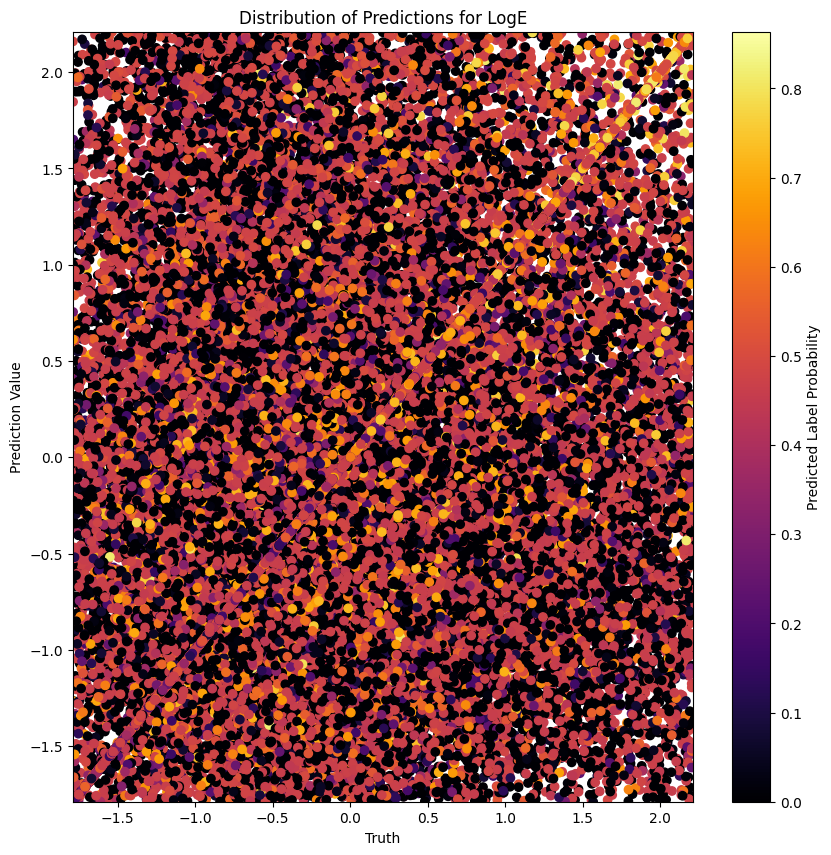

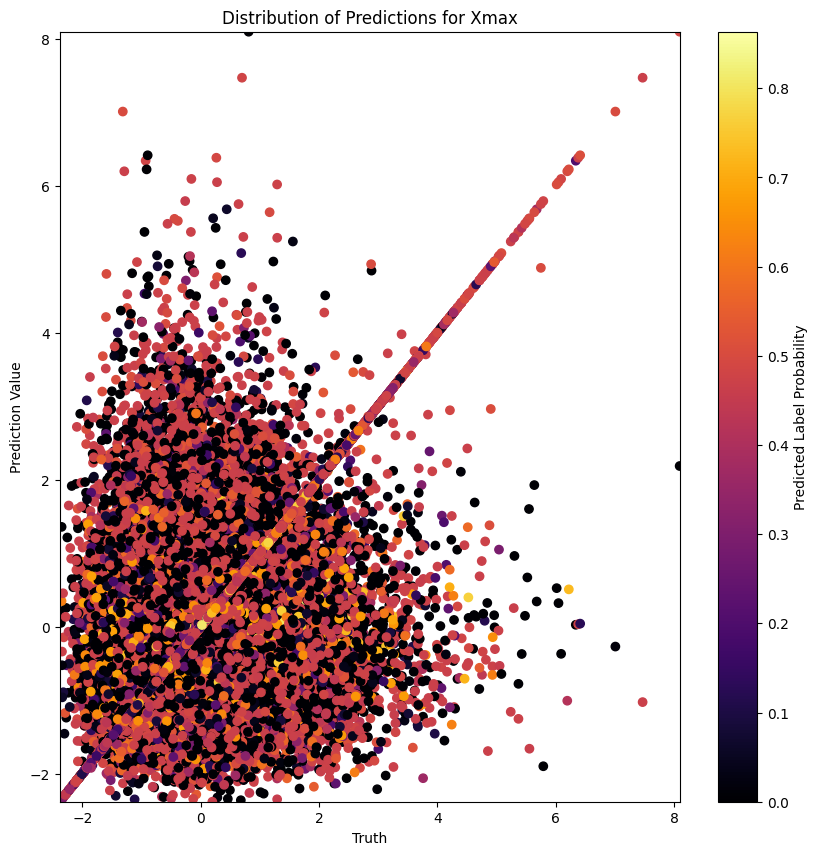

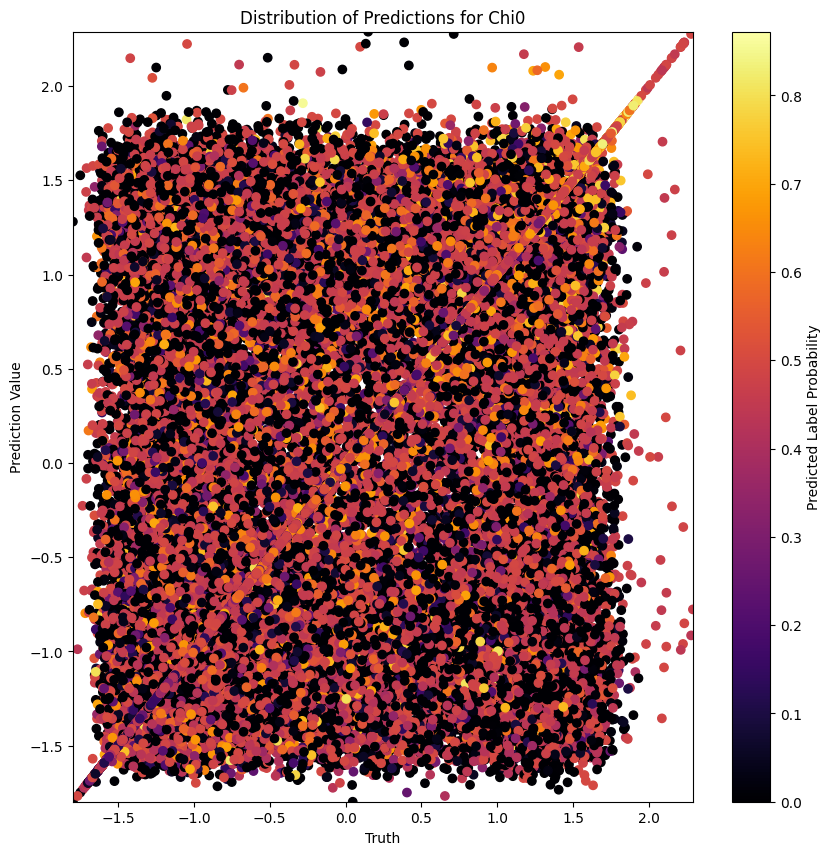

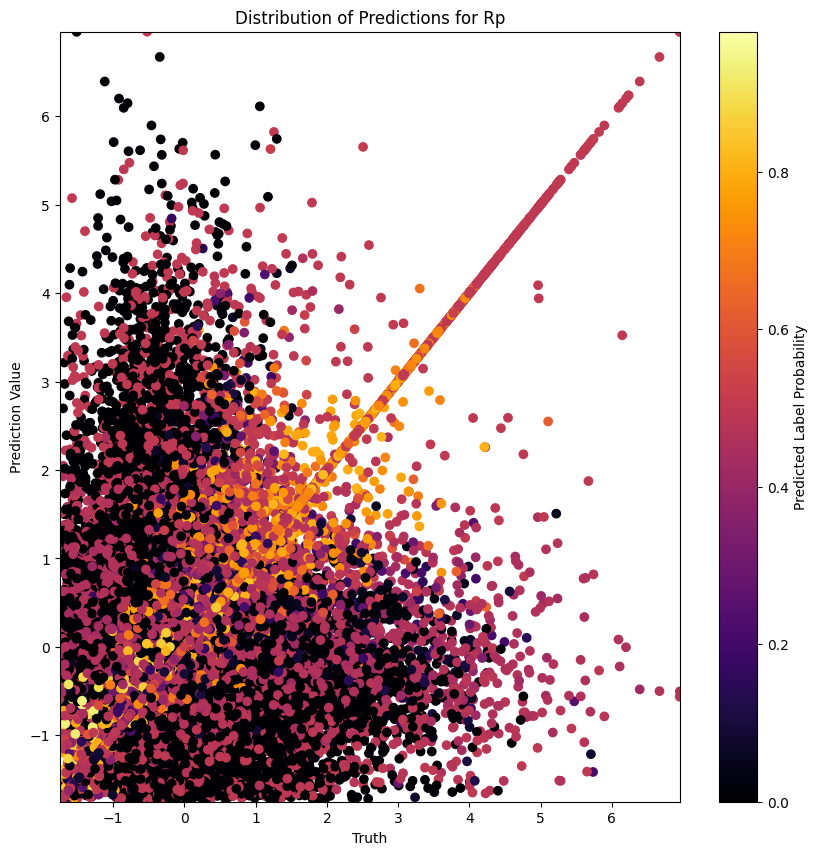

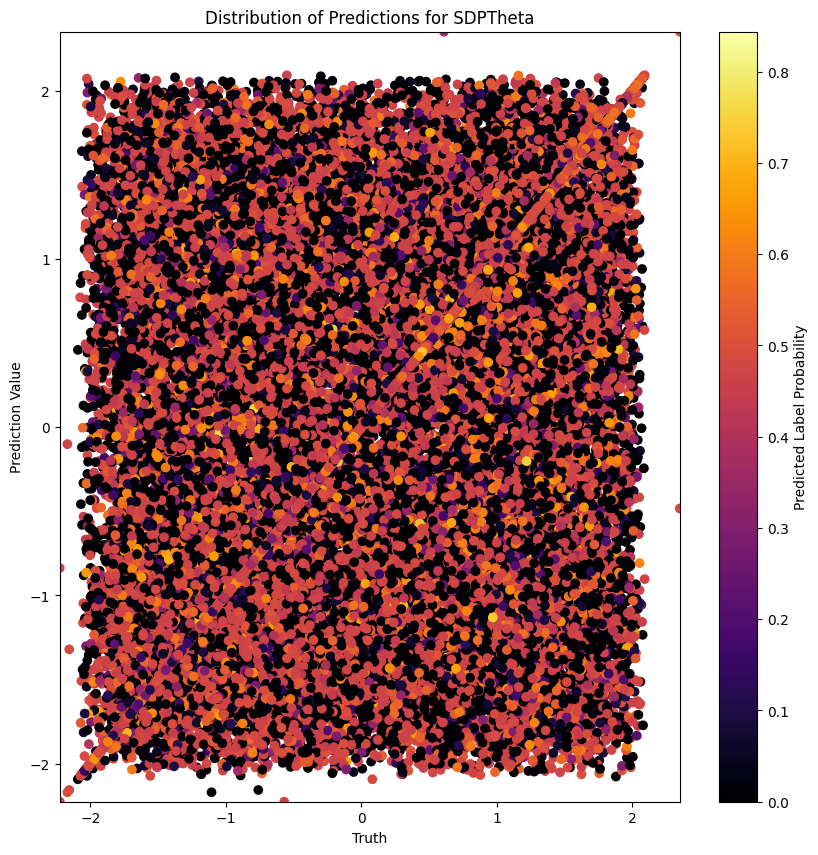

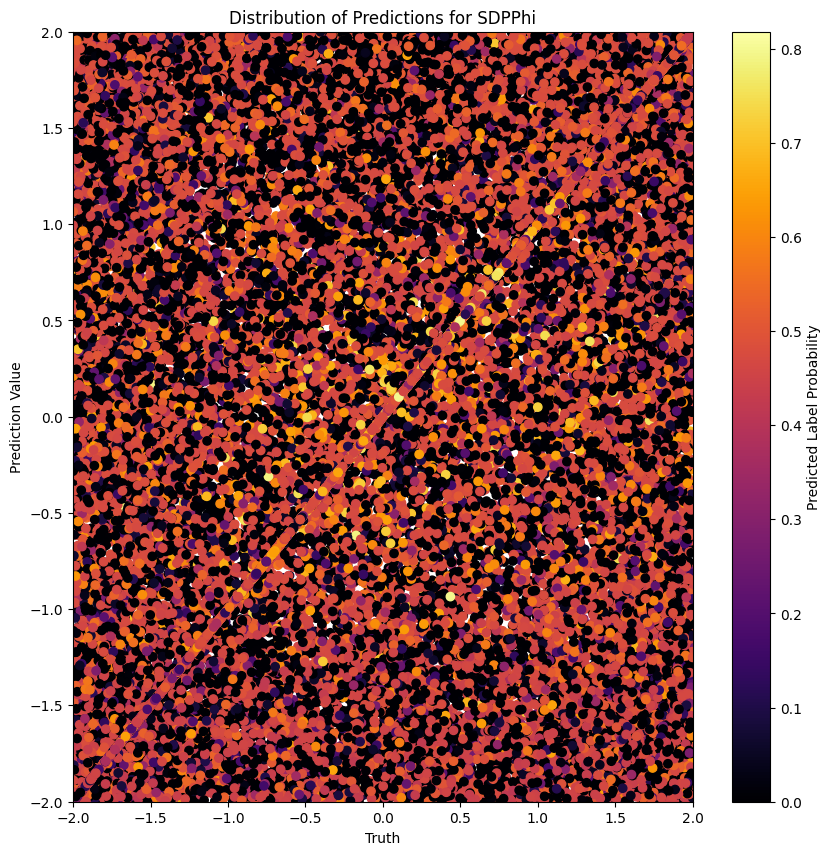

In [33]:
for i, key in enumerate(TruthKeys):
    
    plt.figure(figsize=(10,10))
    plt.title(f'Distribution of Predictions for {key}')

    # plt.scatter(Truth[::,i], RecVals[::,i], alpha=0.1,c = Pred[:,i], cmap='inferno')
    plt.scatter(Truth[::,i], RecVals[::,i], alpha=1,c = Pred[:,i], cmap='inferno')
    plt.xlabel('Truth')
    plt.ylabel('Prediction Value')
    # Set Equal Limits
    min_val = min(Truth[:,i].min(), RecVals[:,i].min())
    max_val = max(Truth[:,i].max(), RecVals[:,i].max())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.colorbar(label='Predicted Label Probability',alpha=1.0)
    plt.show()
    

Plotting for LogE
Plotting for Xmax
Plotting for Chi0
Plotting for Rp
Plotting for SDPTheta
Plotting for SDPPhi


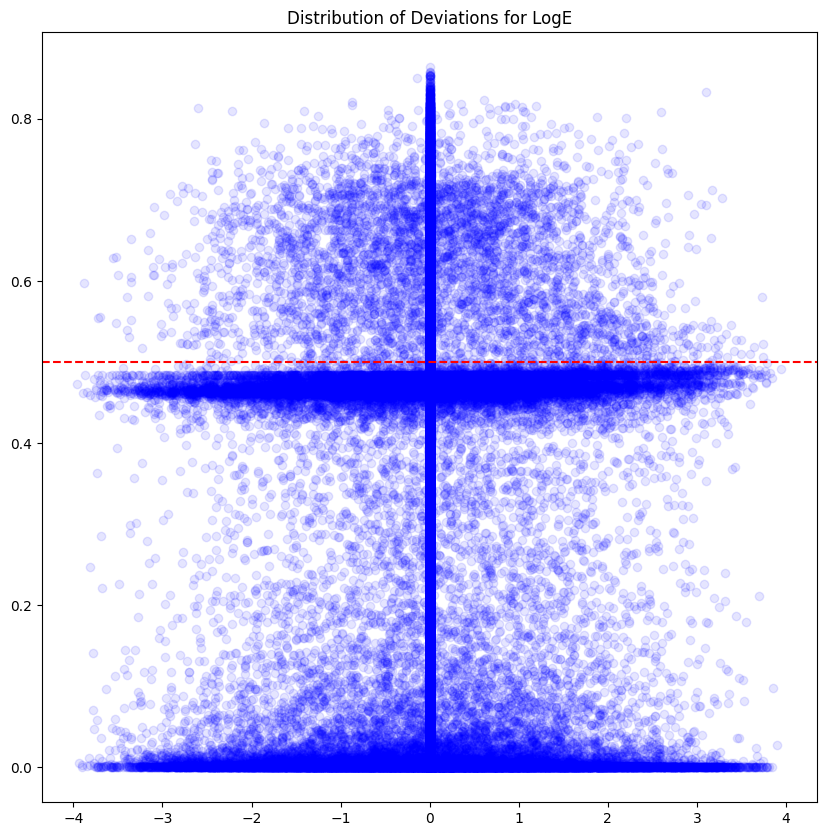

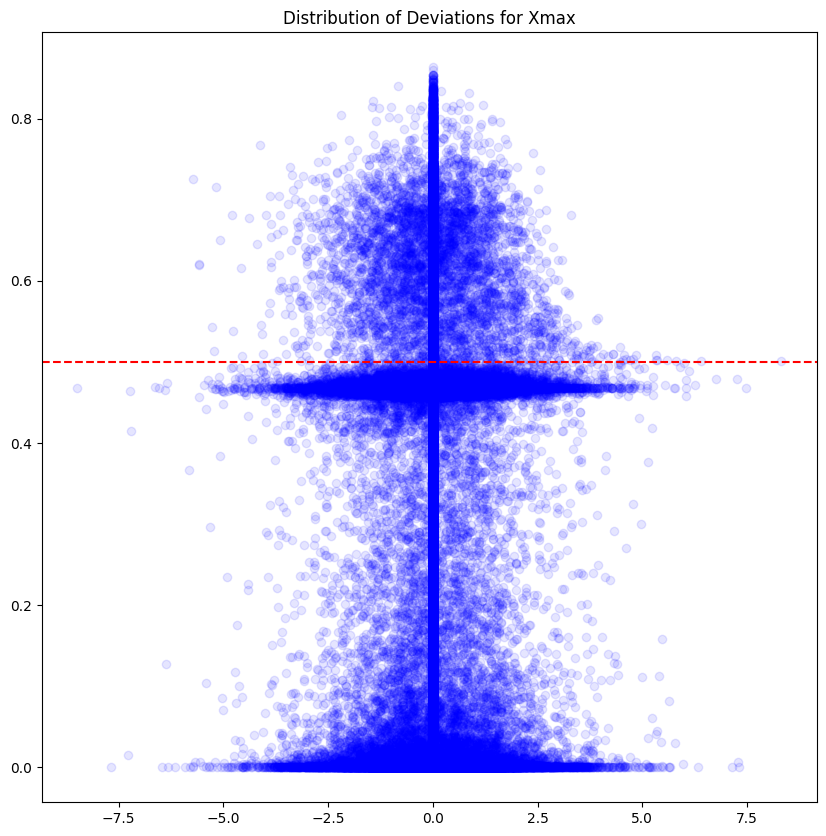

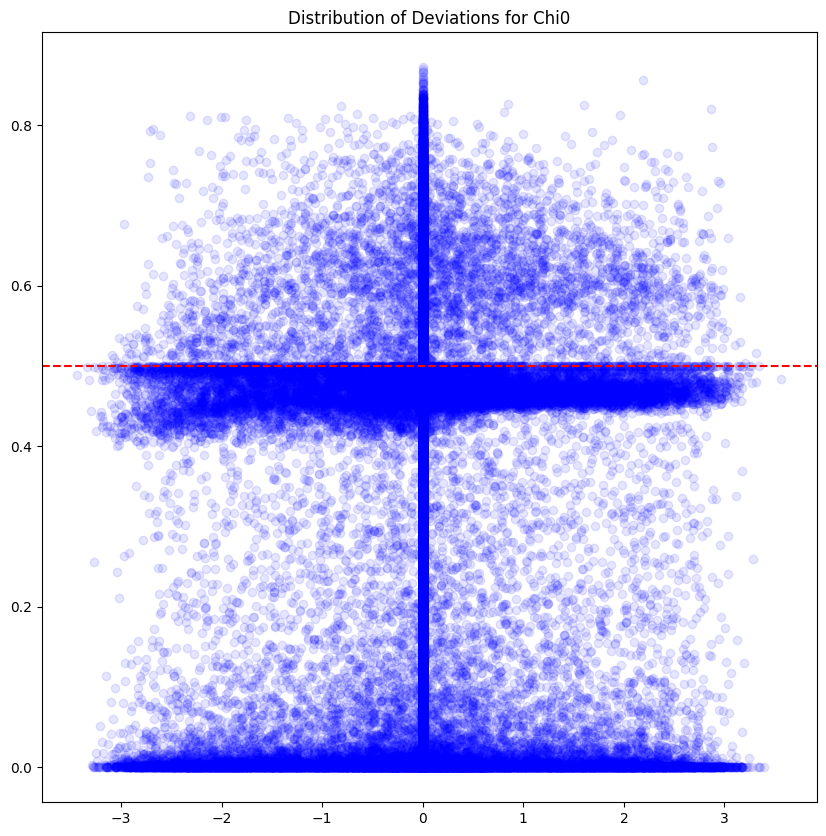

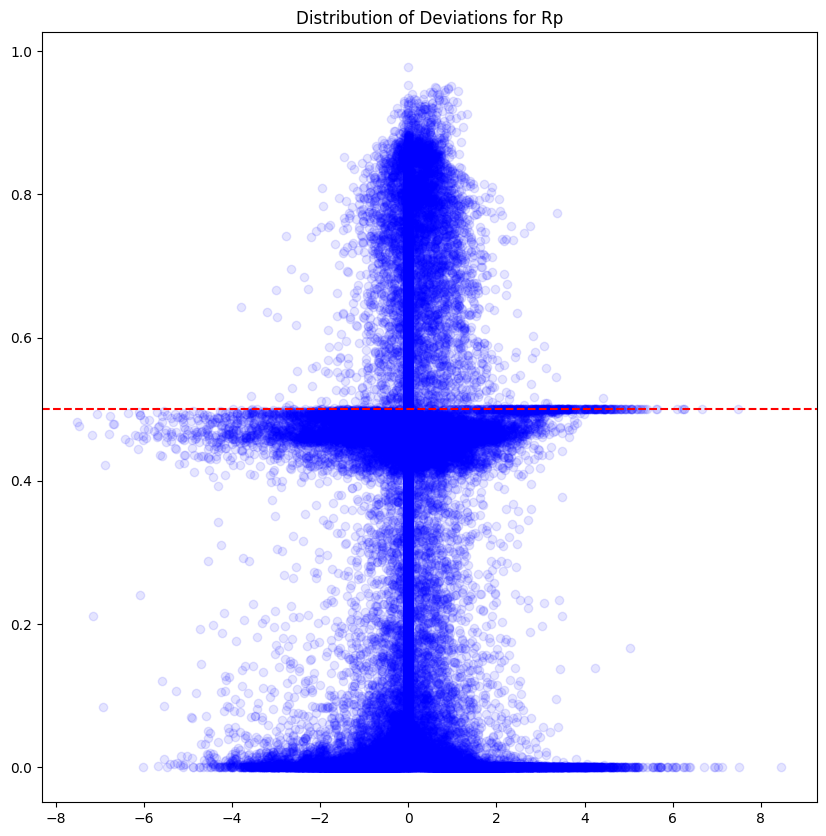

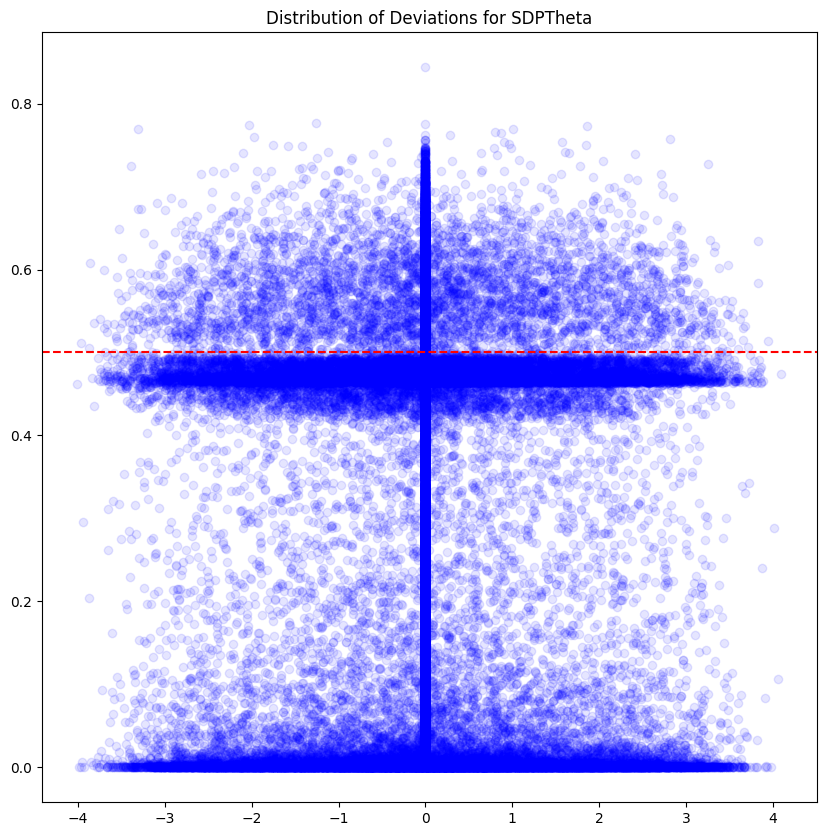

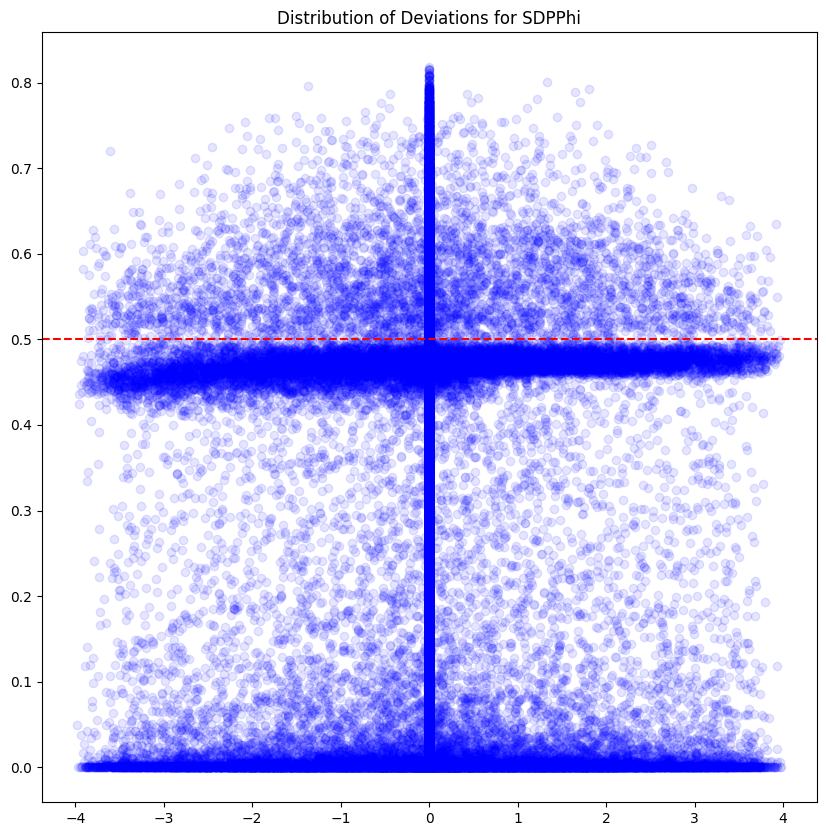

In [34]:
for i,key in enumerate(TruthKeys):
    print(f'Plotting for {key}')

    Deviations = RecVals[:,i] - Truth[:,i]

    plt.figure(figsize=(10,10))
    plt.title(f'Distribution of Deviations for {key}')

    plt.scatter(Deviations,Pred[:,i], alpha=0.1,c = 'blue')    
    plt.axhline(0.5, color='red', linestyle='dashed', label='Decision Boundary')